# Neural Style Transfer

We'll describe an implementation of DeepDream.

In [ ]:
import sys
sys.path.insert(0, "../../../")

## Load Data

We'll load the example image of the Drosophila ssTEM dataset from https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713. Alternatively, you can download an image from the corresponding GiHub repository: http://github.com/unidesigner/groundtruth-drosophila-vnc.

In [ ]:
from PIL import Image
from urllib.request import urlopen
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

url = 'https://s3-eu-west-1.amazonaws.com/pfigshare-u-previews/1288336/preview.jpg'
im_c = Image.open(urlopen(url)).resize((512, 512))

from style_transfer import plot_example
plot_example(im_c)

We'll use the style of the _trencadis_ lizard by Antoni Gaudi  in Parc Guell (Barcelona)

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/commons/d/da/Reptil_Parc_Guell_Barcelona.jpg'
width = 512
height = 512
left = 800
top = 250
im_s = Image.open(urlopen(url)).crop((left,top,left + width, top + height)).resize((512, 512))

plot_example(im_s)


In [ ]:
def gram_matrix(input):
    
    b, c, h, w = input.size()
    F = input.view(b,c,h*w)
    G = torch.bmm(F, F.transpose(1,2))/(h*w)
    return G

# def gram_matrix(input):
#     a, b, c, d = input.size()  
#     # a=batch size(=1)
#     # b=number of feature maps
#     # (c,d)=dimensions of a f. map (N=c*d)

#     features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

#     G = torch.mm(features, features.t())  # compute the gram product

#     # we 'normalize' the values of the gram matrix
#     # by dividing by the number of element in each feature maps.
#     return G.div(a * b * c * d)

We'll download a pretrained model (VGG16).

In [ ]:
import torchvision.models as models
model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

print(model)

The VGG16 is pretrained on the ImageNet dataset and the inputs are normalized wih respect to the mean and standard deviation of the channels of this dataset.

In [ ]:
import numpy as np
mean_ds = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std_ds = np.array([0.229, 0.224, 0.225], dtype=np.float32)

We'll define a function that perform loss maximization through gradient ascend. 

In [ ]:
ind = [0, 2, 5, 7, 10]
layers = [model.features[i] for i in ind ] 
num_iterations=100
beta = 1000

#def style_transfer(im_c, im_s, layer_c, layer_s, beta = 10000, num_iterations=100):

import torch
    
from style_transfer import fwd_hooks, preprocess, deprocess, plot_dream
import numpy as np
from PIL import Image

low = torch.tensor((-mean_ds / std_ds).reshape(1, -1, 1, 1))
high = torch.tensor(((1 - mean_ds) / std_ds).reshape(1, -1, 1, 1))

# content
image_c = preprocess(im_c, mean_ds, std_ds)
with fwd_hooks(layers) as fh:
    out = model(image_c)
content_features = fh.stored[4].detach()

# style
image_s = preprocess(im_s, mean_ds, std_ds)
with fwd_hooks(layers) as fh:
    out = model(image_s)
style_features = fh.stored
gram_targets = [gram_matrix(i).detach() for i in style_features]

image_in = image_c.clone().detach().requires_grad_(True)
optimizer = torch.optim.LBFGS([image_in], lr = 1)

mse_loss = torch.nn.MSELoss(reduction='mean')

model.eval()
model.requires_grad_(False)


for it in range(num_iterations):
    def closure():
        optimizer.zero_grad()

        # content & style
        with fwd_hooks(layers) as fh:
            out = model(image_in)
        content_features_in = fh.stored[4]
        style_features_in = fh.stored
        gram_in = [gram_matrix(i) for i in style_features_in]

        c_loss = 0
        for i,c in enumerate(content_features_in):
            c_loss += mse_loss(c,content_features[i])
        
        s_loss = 0
        for i,g in enumerate(gram_in):
            n_g = g.shape[0]
            s_loss += beta*mse_loss(g,gram_targets[i])/n_g**2

    
        loss = c_loss + beta*s_loss
        loss.backward(retain_graph=True)
        return loss

    optimizer.step(closure)
    image_in.data.clamp_(low, high)

    if (it+1)%1 == 0:
        image_out = Image.fromarray(np.uint8(np.clip(deprocess(image_in.data.clone().detach(), mean_ds, std_ds)*255,0,255)), 'RGB') 
        plot_dream(im_c, image_out)
#return Image.fromarray(np.uint8(np.clip(deprocess(image_c.data.clone().detach(), mean_ds, std_ds)*255,0,255)), 'RGB')

In [11]:
def style_transfer(im_c, im_s, layers, ind_c, ind_s, beta = 1000, num_iterations=100):

    import torch
    from style_transfer import fwd_hooks, preprocess, deprocess, plot_dream
    import numpy as np
    from PIL import Image

    low = torch.tensor((-mean_ds / std_ds).reshape(1, -1, 1, 1))
    high = torch.tensor(((1 - mean_ds) / std_ds).reshape(1, -1, 1, 1))

    # content
    image_c = preprocess(im_c, mean_ds, std_ds)
    with fwd_hooks(layers) as fh:
        out = model(image_c)
    content_features = [fh.stored[i].detach() for i in ind_c]#fh.stored[4].detach()

    # style
    image_s = preprocess(im_s, mean_ds, std_ds)
    with fwd_hooks(layers) as fh:
        out = model(image_s)
    style_features = [fh.stored[i].detach() for i in ind_s]
    gram_targets = [gram_matrix(s) for s in style_features]

    image_in = image_c.clone().detach().requires_grad_(True)
    optimizer = torch.optim.LBFGS([image_in], lr = 1)

    mse_loss = torch.nn.MSELoss(reduction='mean')

    model.eval()
    model.requires_grad_(False)


    for it in range(num_iterations):
        def closure():
            optimizer.zero_grad()

            # content & style
            with fwd_hooks(layers) as fh:
                out = model(image_in)
            content_features_in = [fh.stored[i] for i in ind_c]#fh.stored[4]
            style_features_in = [fh.stored[i] for i in ind_s]#fh.stored
            gram_in = [gram_matrix(i) for i in style_features_in]

            c_loss = 0
            for i,c in enumerate(content_features_in):
                c_loss += mse_loss(c,content_features[i])
        
            s_loss = 0
            for i,g in enumerate(gram_in):
                n_g = g.shape[0]
                s_loss += beta*mse_loss(g,gram_targets[i])/n_g**2

            loss = c_loss + beta*s_loss
            loss.backward(retain_graph=True)
            return loss

        optimizer.step(closure)
        image_in.data.clamp_(low, high)

        if (it+1)%1 == 0:
            image_out = Image.fromarray(np.uint8(np.clip(deprocess(image_in.data.clone().detach(), mean_ds, std_ds)*255,0,255)), 'RGB') 
            plot_dream(im_c, image_out)
    return Image.fromarray(np.uint8(np.clip(deprocess(image_c.data.clone().detach(), mean_ds, std_ds)*255,0,255)), 'RGB')

We'll apply deepdreams to the image, using as output the activations of the first ReLU.

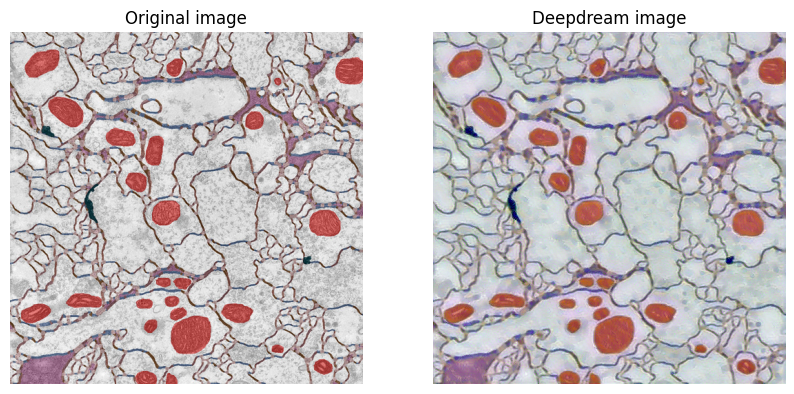

KeyboardInterrupt: 

In [37]:
ind = [0, 2, 5, 7, 10]
layers = [model.features[i] for i in ind ] 
# num_iterations=100
# beta = 1000
ind_c = [4]
ind_s = [0,1,2,3]

im_out  =  style_transfer(im_c, im_s, layers, ind_c, ind_s, beta = 1000, num_iterations=100)


In [33]:
a = [0,1,2,3,4]
a[slice(None,None,1)]

[0, 1, 2, 3, 4]